In [1]:
using Distributions
using LinearAlgebra
using Plots
using Random

In [2]:
function true_likelihood(m, theta)
    if m == 1
        return exp(-theta[1]^2/2)
    else
        return exp(-sum(theta.^2)/2)
    end
end

function true_likelihood(params)
    return true_likelihood(params[1], params[2:end])
end

function true_prior(m, theta)
    # uniform on [-10, 15] for each parameter
    # not formulating as product because we don't want to count theta2
    # for first model
    if m == 1
        if -10 <= theta[1] <= 15
            return (1/25)/2
        else
            return 0
        end
    else
        if -10 <= minimum(theta) <= maximum(theta) <= 15
            return (25^(-2))/2
        else
            return 0
        end
    end
end
function true_prior(params)
    return true_prior(params[1], params[2:end])
end

function true_posterior(m, thetas)
    # ignoring prior
    model_posteriors = normalize([1, sqrt(2*pi)/25], 1)
    if m == 1
        return model_posteriors[1]*pdf(Normal(0,1), thetas[1])
    else
        return model_posteriors[2]*pdf(MultivariateNormal(zeros(2), I), thetas)
    end 
end
function true_posterior(params)
    return true_posterior(params[1], params[2:end])
end

function ess_pdf(m, thetas)
    # ignoring prior
    model_proportions = normalize([1, sqrt(pi)/25], 1)
    if m == 1
        return model_proportions[1]*pdf(Normal(0,sqrt(2)), thetas[1])
    else
        return model_proportions[2]*pdf(MultivariateNormal(zeros(2), 2*I), thetas)
    end  
end
function ess_pdf(params)
    return ess_pdf(params[1], params[2:end])
end

function targeted_pdf(m, thetas)
    # ignoring prior
    model_proportions_ess = normalize([1, sqrt(pi)/25], 1)
    model_difference_from_expectation = abs.([1, 0] .- (1/(1 + sqrt(2*pi)/25)))
    model_proportions = normalize(model_proportions_ess .* model_difference_from_expectation, 1)
    if m == 1
        return model_proportions[1]*pdf(Normal(0,sqrt(2)), thetas[1])
    else
        return model_proportions[2]*pdf(MultivariateNormal(zeros(2), 2*I), thetas)
    end  
end
function targeted_pdf(params)
    return targeted_pdf(params[1], params[2:end])
end

function sumzero(list, returntype = Float64)
    if length(list) == 0
        return zero(Float64)
    else
        return sum(list)
    end
end

function simulate(thetas; likelihood = true_likelihood)
    # one simulation for each theta
    if ~(minimum(likelihood.(thetas)) >= 0)
        print(thetas)
        print(likelihood)
        
        @assert minimum(likelihood.(thetas)) >= 0
    end
    @assert maximum(likelihood.(thetas)) <= 1
    return rand.(Binomial.(1, likelihood.(thetas)))
end

function rejection_estimate(simulated_params, sim_results; importance_pdf = true_prior, f = x -> x[1] == 1, prior = true_prior)
    weights = sim_results .* (prior.(simulated_params)) ./ importance_pdf.(simulated_params)
    return dot(f.(simulated_params), weights) / sum(weights)
end

function ess(simulated_params, sim_results; prior = true_prior, importance_pdf = true_prior)
    weights = sim_results .* (prior.(simulated_params)) ./ importance_pdf.(simulated_params)
    return sum(weights)^2/sum(weights.^2)
end

function categorical_mean(points, weights)
    if (length(points) == 0 )| (sum(weights) == 0)
        return 0
    else
        if length(size(points)) == 1
            points = points'
        end
        relative_weights = weights/sum(weights)
        return points*relative_weights
    end
end

function categorical_second_moment(points, weights)
    
    if (length(points) == 0) | (sum(weights) == 0)
        return 0
    else
        if length(size(points)) == 1
            points = points'
        end
        relative_weights = weights/sum(weights)
        points_squared = [points[:,i]*points[:,i]' for i in 1:size(points, 2)]
        moment = sum([points_squared[i]*relative_weights[i] for i in 1:size(points, 2)])
        if length(moment) == 1
            return moment[1]
        else
            return moment
        end
    end
end

function categorical_covariance(points, weights)
    if (length(points) == 0) | (sum(weights) == 0)
        return 1
    end
    m = categorical_mean(points, weights)
    s = categorical_second_moment(points, weights)
    if s < m*m'
        print(points[weights .> 0], weights[weights .> 0])
    end
    return s - m*m'
end

categorical_covariance (generic function with 1 method)

In [3]:
function simulate_experiment(total_N, sampler::Function, prior, true_likelihood; target_function = x -> x[1] == 1, batch_size = 1)

    thetas = []
    sim_results = []
    importance_pdfs = []
    for batch in 1:Int64(total_N/batch_size)
        next_thetas, next_importance_pdf = sampler(thetas = thetas[1:((batch-1)*batch_size)],
            sim_results = sim_results[1:((batch-1)*batch_size)],
            prior = prior,
            true_likelihood = true_likelihood,
            num_samples = batch_size)
        append!(importance_pdfs, [next_importance_pdf])
        append!(thetas, next_thetas)
        append!(sim_results, simulate(next_thetas, likelihood = true_likelihood))
    end
    return thetas, sim_results, x -> sum([q(x) for q in importance_pdfs])/length(importance_pdfs)
end

function prior_sampler(;thetas = nothing, sim_results = nothing, prior = true_prior, true_likelihood = nothing, num_samples = 1)
    # assuming prior is uniform on [-10, 15] in relevant parameters, uniform over two models
    @assert prior([1,2,3]) == 1/50
    @assert prior([2,2,2]) == 1/1250
    models = rand(Categorical([0.5, 0.5]), num_samples)
    thetas = rand(Product([Uniform(-10,15), Uniform(-10, 15)]), num_samples)
    return [vcat(models[i], thetas[:,i]) for i in 1:num_samples], prior
end

function posterior_sampler(;thetas = nothing, sim_results = nothing, prior = true_prior, true_likelihood = nothing, num_samples = 1)
    # ignoring prior
    @assert true_likelihood([1,2,3]) == exp(-2)
    @assert true_likelihood([2,2,2]) == exp(-4)
    models = rand(Categorical(normalize([1, sqrt(2*pi)/25], 1)), num_samples)
    thetas = rand(Product([Normal(0,1), Normal(0,1)]), num_samples)
    return [vcat(models[i], thetas[:,i]) for i in 1:num_samples], true_posterior
end

function targeted_sampler(;thetas = nothing, sim_results = nothing, prior = true_prior, true_likelihood = true_likelihood, num_samples = 1)
    @assert true_likelihood([1,2,3]) == exp(-2)
    @assert true_likelihood([2,2,2]) == exp(-4)
    model_proportions_ess = normalize([1, sqrt(pi)/25], 1)
    model_difference_from_expectation = abs.([1, 0] .- (1/(1 + sqrt(2*pi)/25)))
    model_proportions = normalize(model_proportions_ess .* model_difference_from_expectation, 1)
    models = rand(Categorical(model_proportions), num_samples)
    thetas = rand(Product([Normal(0,sqrt(2)), Normal(0,sqrt(2))]), num_samples)
    return [vcat(models[i], thetas[:,i]) for i in 1:num_samples], targeted_pdf
end

function ess_sampler(;thetas = nothing, sim_results = nothing, prior = true_prior, true_likelihood = nothing, num_samples = 1)
    @assert true_likelihood([1,2,3]) == exp(-2)
    @assert true_likelihood([2,2,2]) == exp(-4)
    models = rand(Categorical(normalize([1, sqrt(pi)/25], 1)), num_samples)
    thetas = rand(Product([Normal(0,sqrt(2)), Normal(0,sqrt(2))]), num_samples)
    return [vcat(models[i], thetas[:,i]) for i in 1:num_samples], ess_pdf
end

    

ess_sampler (generic function with 1 method)

In [4]:
function experiment_squared_error(total_N::Int64, sampler::Function, prior, true_likelihood; num_trials = 1000, batch_size = 1)
    
    
    errors = zeros(num_trials)
    effective_sample_sizes = zeros(num_trials)
    
    target_function = x -> x[1] == 1
    posterior_mean = (1/(1 + sqrt(2*pi)/25))
    importance_pdf = nothing
    for i in 1:num_trials
        params, sim_results, importance_pdf = simulate_experiment(total_N, sampler, prior, true_likelihood; batch_size = batch_size)
        estimated_mean = rejection_estimate(params, sim_results, importance_pdf = importance_pdf, f = target_function, prior = prior)        
        errors[i] = (posterior_mean - estimated_mean)^2
        effective_sample_sizes[i] = ess(params, sim_results, importance_pdf = importance_pdf, prior = prior)
    end
    if num_trials == 1
        return errors[1], importance_pdf
    else
        return (errors, importance_pdf, effective_sample_sizes)
    end
end

function experiment_squared_error(total_Ns::Vector, sampler::Function, prior, true_likelihood; num_trials = 1000, num_rounds = 1)
    errors_and_pdfs = [experiment_squared_error(n, sampler, prior, true_likelihood, num_trials = num_trials, batch_size = Int64(n/num_rounds)) for n in total_Ns]
    
    errors = [out[1] for out in errors_and_pdfs]
    pdfs = [out[2] for out in errors_and_pdfs]
    effective_sample_sizes = [out[3] for out in errors_and_pdfs]
    
    return errors, pdfs, effective_sample_sizes
end

experiment_squared_error (generic function with 2 methods)

In [5]:
prior_dict = Dict("sampler" => prior_sampler,
    "label" => "prior",
    "num_rounds" => 1,
    "plot_offset" => 2^(-0.15),
)
posterior_dict = Dict("sampler" => posterior_sampler,
    "label" => "posterior",
    "num_rounds" => 1,
    "plot_offset" => 2^(-0.05),
)
ess_dict = Dict("sampler" => ess_sampler,
    "label" => "maximum ESS",
    "num_rounds" => 1,
    "plot_offset" => 2^(0.05),
)
targeted_dict = Dict("sampler" => targeted_sampler,
    "label" => "targeting mean",
    "num_rounds" => 1,
    "plot_offset" => 2^(0.15),
)
all_result_dicts = [prior_dict,
    posterior_dict,
    ess_dict,
    targeted_dict]

4-element Array{Dict{String,Any},1}:
 Dict("label" => "prior","num_rounds" => 1,"plot_offset" => 0.9012504626108302,"sampler" => prior_sampler)           
 Dict("label" => "posterior","num_rounds" => 1,"plot_offset" => 0.9659363289248456,"sampler" => posterior_sampler)   
 Dict("label" => "maximum ESS","num_rounds" => 1,"plot_offset" => 1.0352649238413776,"sampler" => ess_sampler)       
 Dict("label" => "targeting mean","num_rounds" => 1,"plot_offset" => 1.109569472067845,"sampler" => targeted_sampler)

In [6]:
total_ns = 2 .^(7:15)
num_trials = 1000
Random.seed!(300)

function test_squared_error(sampler::Function, num_rounds::Int64; num_trials = num_trials)
    
    return experiment_squared_error(total_ns, sampler, true_prior, true_likelihood, num_trials = num_trials, num_rounds = num_rounds)
end

for dict in all_result_dicts
    println(dict["label"])
    @time dict["errors"], dict["single_importance_pdfs"], dict["effective_sample_sizes"] = test_squared_error(dict["sampler"], dict["num_rounds"])
end

prior
215.879509 seconds (2.97 G allocations: 141.610 GiB, 7.06% gc time)
posterior
519.918689 seconds (3.84 G allocations: 173.818 GiB, 3.45% gc time)
maximum ESS
528.932044 seconds (3.82 G allocations: 172.614 GiB, 3.32% gc time)
targeting mean
582.190322 seconds (4.55 G allocations: 235.709 GiB, 5.43% gc time)


50.020000000000024
90.88718453747079
93.3795614672595
58.57864376269048


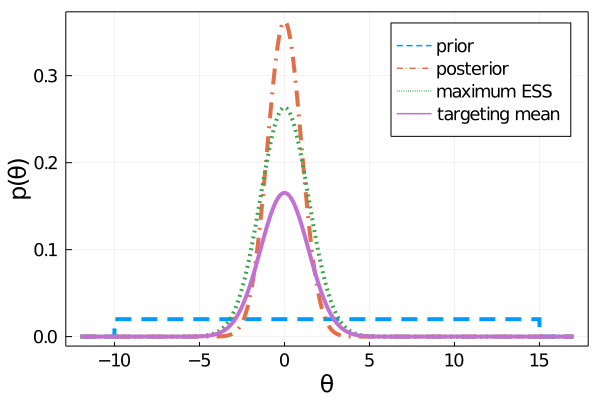

In [7]:
p = plot()

legendfontsize = 12
tickfontsize = 12
labelfontsize = 16


styles = [:dash, :dashdot, :dot, :solid]
p = plot()
for (dict, style) in zip(all_result_dicts, styles)
    theta1s = -12:0.01:17
    thetas = [[1, theta1, 0] for theta1 in theta1s]
    println(sum(dict["single_importance_pdfs"][end].(thetas)))
    plot!(theta1s, dict["single_importance_pdfs"][end].(thetas),
        label = dict["label"],
        linewidth = 4,
        framestyle = :box,
        linestyle = style,
        ylabel = "p(θ)",
        xlabel = "θ",
        yguidefontsize = labelfontsize, ytickfontsize = tickfontsize, legendfontsize = legendfontsize, 
        xguidefontsize = labelfontsize, xtickfontsize = tickfontsize,
    )
end

plot(p)

In [8]:
for dict in all_result_dicts
    for prefix in ["error", "effective_sample_size"]
        dict[prefix*"_means"] = mean.(dict[prefix*"s"])
        dict[prefix*"_vars"] = var.(dict[prefix*"s"])
    end
end

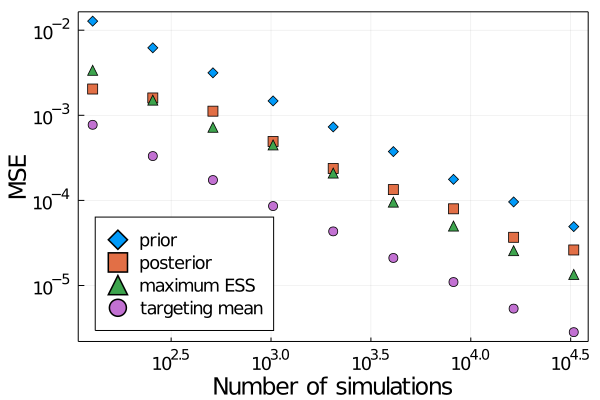

In [9]:

marker_size = 5
markers = [(m, marker_size) for m in [:diamond, :square, :utriangle, :circle]]
p = scatter()
for (dict, marker) in zip(all_result_dicts, markers)
    scatter!(reverse(total_ns), reverse(dict["error_means"]),
        xscale = :log10,
        yscale = :log10,
        label = dict["label"],
        framestyle = :box,
        m = marker,
        ylabel = "MSE",
        xlabel = "Number of simulations",
        yguidefontsize = labelfontsize, ytickfontsize = tickfontsize, legendfontsize = legendfontsize, 
        xguidefontsize = labelfontsize, xtickfontsize = tickfontsize,
        legend = :bottomleft)
end
plot(p)

prior: 0.055240061442057294
posterior: 0.40209424633530527
maximum ESS: 0.45149225882062044
targeting mean: 0.3498526246008944


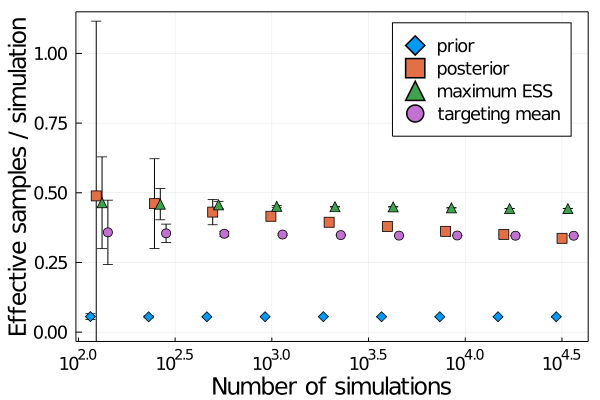

In [10]:
p = scatter()
for (dict, marker) in zip(all_result_dicts, markers)
    println(dict["label"], ": ", mean(dict["effective_sample_size_means"][.~ isnan.(dict["effective_sample_size_means"])]./total_ns[.~ isnan.(dict["effective_sample_size_means"])]))
    scatter!(reverse(total_ns).*dict["plot_offset"], reverse(dict["effective_sample_size_means"])./reverse(total_ns),
        xscale = :log10,
        yerr = sqrt.(dict["effective_sample_size_vars"])./sqrt(num_trials)./reverse(total_ns),
        label = dict["label"],
        framestyle = :box,
        m = marker,
        ylabel = "Effective samples / simulation",
        xlabel = "Number of simulations",
        ylim = [0, :auto],
        yguidefontsize = labelfontsize, ytickfontsize = tickfontsize, legendfontsize = legendfontsize, 
        xguidefontsize = labelfontsize, xtickfontsize = tickfontsize,
        legend = :topright)
end
plot(p)

prior: 17.408275378764166
posterior: 6.094098758562355
maximum ESS: 4.642243449731142
targeting mean: 1.0


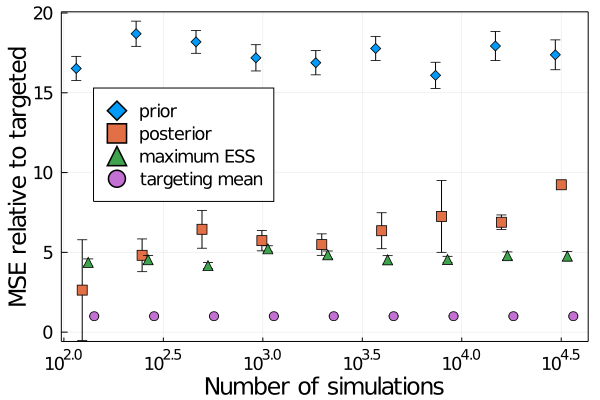

In [11]:
p = scatter()
for (dict, marker) in zip(all_result_dicts, markers)
    println(dict["label"], ": ", mean(dict["error_means"]./targeted_dict["error_means"]))
    scatter!(reverse(total_ns).*dict["plot_offset"], reverse(dict["error_means"]./targeted_dict["error_means"]),
        xscale = :log10,
        ylim = [0, :auto],
        yerr = sqrt.(dict["error_vars"]./num_trials)./targeted_dict["error_means"],
        label = dict["label"],
        framestyle = :box,
        m = marker,
        ylabel = "MSE relative to targeted",
        xlabel = "Number of simulations",
        yguidefontsize = labelfontsize, ytickfontsize = tickfontsize, legendfontsize = legendfontsize, 
        xguidefontsize = labelfontsize, xtickfontsize = tickfontsize,
        legend = (0.15, 0.7))
end
plot(p)

